<a href="https://colab.research.google.com/github/dzchrist2/LeafyGreens_VSML_Model_Prototype/blob/master/LettuceNPK_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import PIL
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

Importing Dataset

In [ ]:
path_str = "/content/drive/MyDrive/Lettuce_Nutrient_Dataset"
data_path = Path(path_str)
# data = tf.keras.utils.get_file('data_path')
all_healthy = list(data_path.glob('Healthy/*'))
all_nitrogen = list(data_path.glob('Nitrogen/*'))
all_phosphorus = list(data_path.glob('Phosphorus/*'))
all_potassium = list(data_path.glob('Potassium/*'))
print(all_healthy)
# PIL.Image.open(str(all_healthy[1]))

[PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn12.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn2.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn10.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn3.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn1.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn11.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn5.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn7.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn9.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn6.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn4.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/Healthy/fn8.png'), PosixPath('/content/drive/MyDrive/Lettuce_Nutrient_Dataset/H

Train/Valiation Split

In [ ]:
height, width=224, 224

train_set = tf.keras.preprocessing.image_dataset_from_directory(
data_path,
validation_split=0.2,
subset="training",
seed=123,
image_size=(height,width))

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
data_path,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(height,width))

class_names = train_set.class_names
print(class_names)

Found 212 files belonging to 4 classes.
Using 170 files for training.
Found 212 files belonging to 4 classes.
Using 42 files for validation.
['Healthy', 'Nitrogen', 'Phosphorus', 'Potassium']


Visualize Dataset

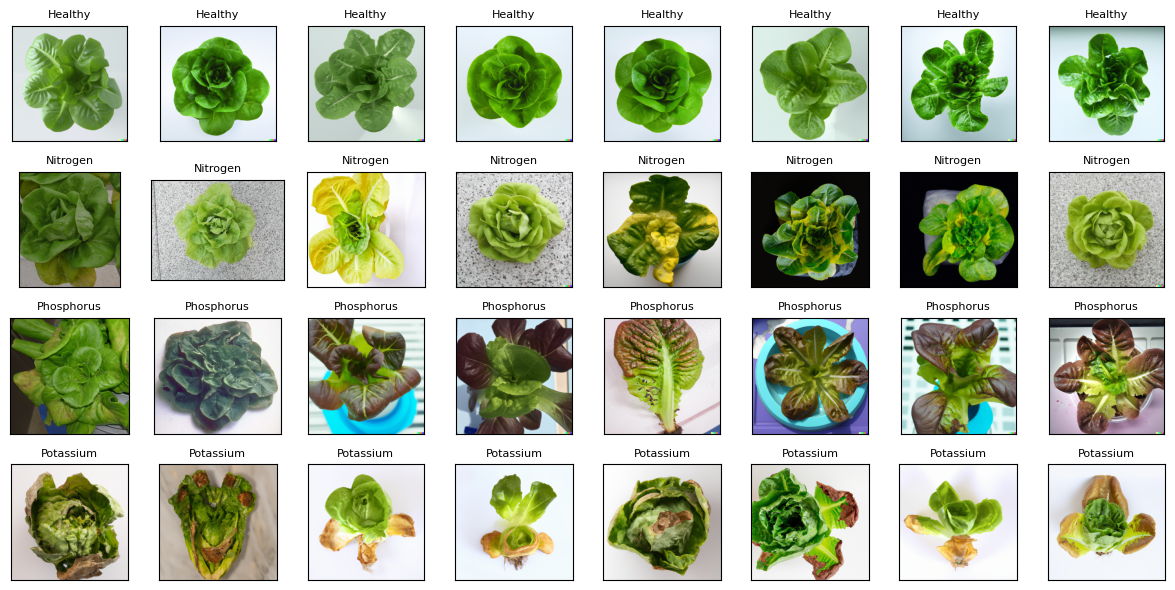

In [ ]:
nrows = len(class_names)
ncols = 8
plt.figure(figsize=(ncols*1.5, nrows*1.5))
for row in range(nrows):
    class_name = class_names[row]
    img_paths = [os.path.join(path_str, class_name, filename)
        for filename in os.listdir(os.path.join(path_str, class_name))]
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols + col + 1)
        img = plt.imread(img_paths[col])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(class_name, fontsize=8)
plt.tight_layout()
plt.show()

Data Augmentation

In [ ]:
# initialize the training training data augmentation object
trainAug = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest",
	validation_split=0.2)

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = keras.preprocessing.image.ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# initialize the training generator
train_gen = trainAug.flow_from_directory(
		 data_path,
		 class_mode = "categorical",
		 target_size=(224, 224),
		color_mode="rgb",
		shuffle=True,
		subset='training')

# initialize the validation generator
val_gen = trainAug.flow_from_directory(
	data_path,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	subset='validation')

"""
pic = trainAug.flow_from_directory(data_path, batch_size=1)
plt.figure(figsize=(16, 16))
#Plots our figures
plt.imshow(pic)
"""

Found 171 images belonging to 4 classes.
Found 41 images belonging to 4 classes.


'\npic = trainAug.flow_from_directory(data_path, batch_size=1)\nplt.figure(figsize=(16, 16))\n#Plots our figures\nplt.imshow(pic)\n'

NOT WORKING Canny Edge Detection

In [ ]:
# train_grey = tf.image.rgb_to_grayscale(train_set)
#train_nparray = np.array(list(train_set))
#train_nparray = train_nparray.astype(np.uint8)
#edges = cv2.Canny(train_nparray, 100, 200)

Constructing Neural Network with ResNet

In [ ]:
dnn_model = tf.keras.Sequential()

imported_model= tf.keras.applications.ResNet50(include_top=False,
input_tensor=keras.Input(shape=(224,224,3)),
pooling='avg',classes=4,
weights='imagenet')
for layer in imported_model.layers:
  layer.trainable=False

dnn_model.add(imported_model) # 1st Layer from imported ResNet
dnn_model.add(Flatten())      # Additional flatten layer
dnn_model.add(Dense(512, activation='relu'))    # Additional dense layer with 512 neurons
dnn_model.add(Dense(4, activation='softmax'))   # Output dense layer with 4 neurons


Model Summary

In [ ]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 4)                 2052      
 apper)                                                          
                                                                 
Total params: 24638852 (93.99 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

Model Compilation

In [ ]:
dnn_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Fit Model to Data

In [ ]:
tain_history = dnn_model.fit(
train_set,
validation_data=validation_set,
epochs=15)

Epoch 1/25
6/6 [==============================] - 59s 8s/step - loss: 2.4876 - accuracy: 0.3882 - val_loss: 2.4792 - val_accuracy: 0.4524
Epoch 2/25
6/6 [==============================] - 50s 8s/step - loss: 2.0395 - accuracy: 0.6294 - val_loss: 1.3839 - val_accuracy: 0.5714
Epoch 3/25
6/6 [==============================] - 50s 8s/step - loss: 1.0581 - accuracy: 0.7118 - val_loss: 0.4198 - val_accuracy: 0.8333
Epoch 4/25
6/6 [==============================] - 47s 7s/step - loss: 0.5530 - accuracy: 0.7941 - val_loss: 0.4776 - val_accuracy: 0.8810
Epoch 5/25
6/6 [==============================] - 59s 9s/step - loss: 0.2483 - accuracy: 0.9294 - val_loss: 0.5620 - val_accuracy: 0.8333
Epoch 6/25
6/6 [==============================] - 48s 7s/step - loss: 0.1636 - accuracy: 0.9647 - val_loss: 0.4027 - val_accuracy: 0.8810
Epoch 7/25
6/6 [==============================] - 47s 7s/step - loss: 0.1286 - accuracy: 0.9647 - val_loss: 0.2626 - val_accuracy: 0.9048
Epoch 8/25
6/6 [==================

Make Predictions

In [ ]:
# Preprocess Input
image=cv2.imread(str(all_nitrogen[50]))
image_resized= cv2.resize(image, (height, width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

# Predict
model_pred=dnn_model.predict(image)
predicted_class=class_names[np.argmax(model_pred)]
print("The predicted category is", predicted_class)

(1, 224, 224, 3)
1/1 [==============================] - 1s 997ms/step
The predicted category is Nitrogen


ResNet Model Metrics

In [ ]:
accuracy_score = dnn_model.evaluate(validation_set)

NameError: name 'dnn_model' is not defined